In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.detection_dataset_loader import *
from scipy.spatial.transform import Rotation as R
from data.data_utils.data_reader import *
import math
import numpy.matlib as npm


/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [3]:
def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add third point
    #x3, y3 = bbox[0][4], bbox[1][4]   
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]


In [234]:
def get_augmentation_parameters( training):
        if training:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.5:
                        translate_x = random.randint(-5, 5)
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        translate_y = random.randint(-5, 5)
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.8:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.0:
                        ang = random.randint(-50, 50)
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1

                    # if np.random.random_sample() >= 0.5:
                    #    sc_x += ((random.random() * 2) - 1.) / 10.

                    # if np.random.random_sample() >= 0.5:
                    #    sc_y += ((random.random() * 2) - 1.) / 10.


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

        return rot, tr, sc, image_translate_x, image_translate_y, ang

In [235]:
training=True
base_path = '../../../Data/'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)

camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
ln = int(len(list_files) * 0.5)
final_sample = len(list_files)

# ln = int(10 * 0.5)
# final_sample = 10
        
if training:
            list_files = list_files[:ln]
            list_camera_paths = camera_paths[:ln]
            list_lidar_paths = lidar_paths[:ln]
            list_label_paths = label_paths[:ln]
            list_calib_paths = calib_paths[:ln]
else:
            list_camera_paths = camera_paths[ln:final_sample]
            list_lidar_paths = lidar_paths[ln:final_sample]
            list_label_paths = label_paths[ln:final_sample]
            list_calib_paths = calib_paths[ln:final_sample]
            list_files = list_files[ln:final_sample]


In [236]:
i_c = 2

In [237]:
rot, tr, sc, image_translate_x, image_translate_y, ang = get_augmentation_parameters(True)
print(rot)
print(tr)
print(sc)
print(ang)
data_reader_obj = DataReader(list_camera_paths[i_c],
                             list_calib_paths[i_c], 
                             list_label_paths[i_c], 
                             list_lidar_paths[i_c], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=True)

# data_reader_obj.lidar_reader = LidarReader(list_lidar_paths[i_c], list_calib_paths[i_c], list_camera_paths[i_c], rot, tr, sc)
camera_image = data_reader_obj.read_image()
lidar_image = data_reader_obj.lidar_reader.read_lidar()
_, label, directions = data_reader_obj.label_reader.read_label()
# label2 = get_target(label, directions,  anchors=anchors)

[[ 0.89879405 -0.43837115  0.          0.        ]
 [ 0.43837115  0.89879405  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[0.        ]
 [0.        ]
 [0.24990896]
 [0.        ]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
26


In [238]:
(26.25161283/40 - 1) / 1.5

-0.22913978616666672

In [239]:
-0.22913978616666672 * 1.5 + 1

0.6562903207499999

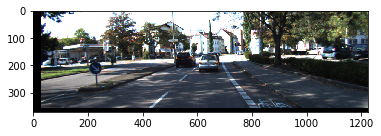

In [240]:
plt.imshow(camera_image)
plt.show()

In [241]:
lidar_image.shape

(512, 448, 41)

In [242]:
np.max(lidar_image), np.min(lidar_image)

(1.0, 0.0)

<Figure size 432x288 with 0 Axes>

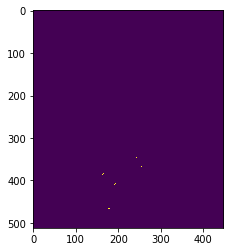

In [243]:
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

# img = lidar_image[:, :, 0] > 0.7
img = img[:, :, 0] > 180


ax.imshow(img)
plt.show()

<Figure size 432x288 with 0 Axes>

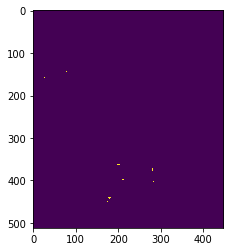

In [187]:
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = img[:, :, 0] > 170

ax.imshow(img)
plt.show()

<Figure size 432x288 with 0 Axes>

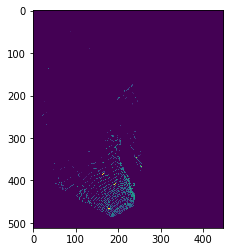

In [244]:
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = img[:, :, 0]

ax.imshow(img)
plt.show()

<Figure size 432x288 with 0 Axes>

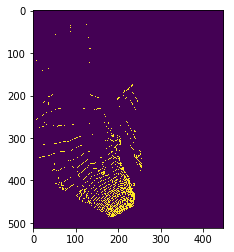

In [245]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = np.clip(np.mean(img[:, :, 1:], 2), 0, 1)

ax.imshow(img)

plt.show()

397.0146504840947 185.77098590788768 22.174392558868494 24.569085618136032 9.208337898683805 13.356026035785764 -65.100322
369.5250782410174 159.81641211393037 21.45700290160169 29.751446982391794 9.888634345263798 15.695767823076704 -67.392154
336.96121771462543 168.06804106075714 20.1820539008573 31.519451120774015 9.497699898178851 14.91585389397972 -68.53807
353.2378733135563 258.3347044195734 14.801192374294203 24.23767810781288 10.512891577974717 14.428407688294111 -139.58486200000002
333.2228113871702 248.39259980997014 14.232843531284505 22.97529903969762 10.578597150336947 15.110832376253969 -139.58486200000002


<Figure size 432x288 with 0 Axes>

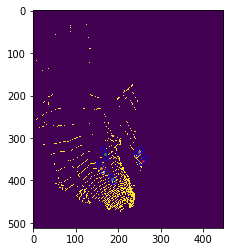

In [246]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)

img = np.clip(np.mean(img[:, :, 5:25], 2), 0, 1)

ax.imshow(img)

# print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    d = label[i][5] 
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    plt.scatter([y], [x], s=3)
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=.75,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    print(x, y, z, w, h, d, -label[i][6]*57.2958)


plt.show()


<Figure size 432x288 with 0 Axes>

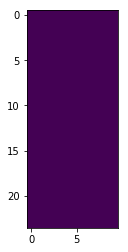

In [247]:
plt.clf()
fig,ax = plt.subplots(1)
# 338.0429604813074 228.30154100755286 26.251612833821447 22.992421447451175 9.299607994828627 15.695767823076704 -95.111028

img = (lidar_image*127. + 127.)
img = np.clip(np.mean(img[338-12:338+12, 228-5:228+5, 5:25], 2), 0, 1)
ax.imshow(img)
plt.show()

13.356026035785764 9.208337898683805 24.569085618136032
185.77098590788768 22.174392558868494 397.0146504840947
15.695767823076704 9.888634345263798 29.751446982391794
159.81641211393037 21.45700290160169 369.5250782410174
14.91585389397972 9.497699898178851 31.519451120774015
168.06804106075714 20.1820539008573 336.96121771462543
14.428407688294111 10.512891577974717 24.23767810781288
258.3347044195734 14.801192374294203 353.2378733135563
15.110832376253969 10.578597150336947 22.97529903969762
248.39259980997014 14.232843531284505 333.2228113871702


<Figure size 432x288 with 0 Axes>

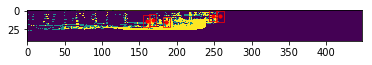

In [248]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*255. + 0.)
# Display the image
img = np.clip(np.mean(img.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z-h/2, s=10, c='r')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle=0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
#     break


plt.show()


<Figure size 432x288 with 0 Axes>

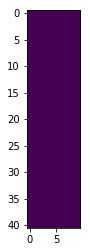

In [249]:
plt.clf()
fig,ax = plt.subplots(1)
# 15.695767823076704 9.299607994828627 22.992421447451175
# 228.30154100755286 26.251612833821447 338.0429604813074


# 15.695767823076704 9.27595552418579 23.02796916185907
# 217.70232382225657 26.251612833821447 316.5861802528655
img = (lidar_image*127. + 127.)
img = np.clip(np.mean(img.transpose()[:, 228-5:228+5, 338-11:338+11], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)
plt.show()